# Configuración del entorno

In [20]:
# Preparar espacio de trabajo (Google Colab)
import os, sys
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

mount_path = '/content/drive'
if not os.path.ismount(mount_path):
    drive.mount(mount_path)
else:
    print("Google Drive ya está montado.")
%cd /content/drive/MyDrive/IA-DeteccionFraude

Google Drive ya está montado.
/content/drive/MyDrive/IA-DeteccionFraude


In [21]:
# Crear el archivo de experimentos

%%writefile src/experiments.py
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from typing import Dict, Any, List

sys.path.append(os.path.abspath("src"))
from neural_network import NeuralNetwork
from data_preprocessing import preprocess_data

def run_single_experiment(config: Dict[str, Any], X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, Any]:
    """Ejecuta un único experimento de red neuronal y retorna los resultados."""
    print(f"Corriendo experimento: {config['name']}")
    nn = NeuralNetwork(layers=config['layers'], activations=config['activations'], seed=42)
    history = nn.train(X_train, y_train, epochs=config['epochs'], learning_rate=config['learning_rate'], verbose=False)

    # Obtener las métricas con el umbral óptimo.
    best_threshold, metrics = nn.threshold_optimization(X_test, y_test)

    results = {
        'modelo': 'Red Neuronal',
        'nombre_experimento': config['name'],
        'capas': str(config['layers']),
        'activaciones': str(config['activations']),
        'learning_rate': config['learning_rate'],
        'epochs': config['epochs'],
        'final_loss': history[-1],
        'umbral_optimo': best_threshold,
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score'],
    }

    # Guardar curva de pérdida en la carpeta de resultados.
    plt.figure(figsize=(8, 5))
    plt.plot(history)
    plt.title(f"Curva de Pérdida - {config['name']}")
    plt.xlabel("Época")
    plt.ylabel("Pérdida (MSE)")
    plt.grid(True)
    plt.savefig(f"results/training_curve_{config['name'].replace(' ', '_')}.png")
    plt.close() # Cierra la figura para evitar que se muestre en el notebook.

    return results

def run_baseline_experiment(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, Any]:
    """Ejecuta y evalúa un modelo de regresión logística como baseline."""
    print("Corriendo experimento baseline: Regresión Logística")
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train.ravel())
    y_pred_lr_proba = log_reg.predict_proba(X_test)[:, 1]

    # Encontrar el umbral óptimo para el baseline.
    thresholds = np.linspace(0, 1, 101)
    best_f1 = -1
    best_threshold = 0.5
    for threshold in thresholds:
        y_pred_lr_binary = (y_pred_lr_proba >= threshold).astype(np.int64)
        f1 = f1_score(y_test.ravel(), y_pred_lr_binary, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Obtener métricas con el umbral óptimo.
    y_pred_lr_binary_optimal = (y_pred_lr_proba >= best_threshold).astype(np.int64)
    accuracy = accuracy_score(y_test.ravel(), y_pred_lr_binary_optimal)
    precision = precision_score(y_test.ravel(), y_pred_lr_binary_optimal, zero_division=0)
    recall = recall_score(y_test.ravel(), y_pred_lr_binary_optimal, zero_division=0)

    return {
        'modelo': 'Regresión Logística',
        'nombre_experimento': 'Baseline',
        'capas': 'N/A',
        'activaciones': 'N/A',
        'learning_rate': 'N/A',
        'epochs': 'N/A',
        'final_loss': 'N/A',
        'umbral_optimo': best_threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': best_f1,
    }

def run_all_experiments(df: pd.DataFrame, results_path: str) -> pd.DataFrame:
    """
    Función principal que orquesta la ejecución de todos los experimentos.
    """
    X, y, _, _ = preprocess_data(
        df,
        num_cols=['monto', 'hora', 'n_transacciones_1h', 'tiempo_ultima_transaccion', 'score_riesgo'],
        cat_cols=['pais', 'dispositivo']
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Definir las configuraciones de los experimentos a comparar.
    experiments_configs = [
        {'name': 'Arch_1', 'layers': [X.shape[1], 16, 8, 1], 'activations': ['relu', 'relu', 'sigmoid'], 'learning_rate': 0.05, 'epochs': 500},
        {'name': 'Arch_2_wider', 'layers': [X.shape[1], 32, 16, 1], 'activations': ['relu', 'relu', 'sigmoid'], 'learning_rate': 0.05, 'epochs': 500},
        {'name': 'Arch_3_narrow', 'layers': [X.shape[1], 8, 4, 1], 'activations': ['relu', 'relu', 'sigmoid'], 'learning_rate': 0.05, 'epochs': 500},
        {'name': 'Act_Tanh', 'layers': [X.shape[1], 16, 8, 1], 'activations': ['tanh', 'tanh', 'sigmoid'], 'learning_rate': 0.05, 'epochs': 500},
        {'name': 'LR_High', 'layers': [X.shape[1], 16, 8, 1], 'activations': ['relu', 'relu', 'sigmoid'], 'learning_rate': 0.1, 'epochs': 500},
        {'name': 'LR_Low', 'layers': [X.shape[1], 16, 8, 1], 'activations': ['relu', 'relu', 'sigmoid'], 'learning_rate': 0.001, 'epochs': 500},
        {'name': 'Epochs_High', 'layers': [X.shape[1], 16, 8, 1], 'activations': ['relu', 'relu', 'sigmoid'], 'learning_rate': 0.05, 'epochs': 1000},
    ]

    results_list = []

    # Ejecutar experimentos de Red Neuronal.
    for config in experiments_configs:
        results = run_single_experiment(config, X_train, y_train, X_test, y_test)
        results_list.append(results)

    # Ejecutar experimento Baseline (Regresión Logística).
    baseline_results = run_baseline_experiment(X_train, y_train, X_test, y_test)
    results_list.append(baseline_results)

    df_results = pd.DataFrame(results_list)
    df_results.to_csv(f"{results_path}/performance_comparison.csv", index=False)

    return df_results

Writing src/experiments.py


# Ejecución de experimentos y visualización de resultados

Corriendo experimento: Arch_1
Corriendo experimento: Arch_2_wider
Corriendo experimento: Arch_3_narrow
Corriendo experimento: Act_Tanh
Corriendo experimento: LR_High
Corriendo experimento: LR_Low
Corriendo experimento: Epochs_High
Corriendo experimento baseline: Regresión Logística
Resultados de los experimentos (ordenados por F1-Score):
                modelo nombre_experimento            capas  \
7  Regresión Logística           Baseline              N/A   
2         Red Neuronal      Arch_3_narrow    [13, 8, 4, 1]   
3         Red Neuronal           Act_Tanh   [13, 16, 8, 1]   
4         Red Neuronal            LR_High   [13, 16, 8, 1]   
6         Red Neuronal        Epochs_High   [13, 16, 8, 1]   
0         Red Neuronal             Arch_1   [13, 16, 8, 1]   
5         Red Neuronal             LR_Low   [13, 16, 8, 1]   
1         Red Neuronal       Arch_2_wider  [13, 32, 16, 1]   

                  activaciones learning_rate epochs final_loss  umbral_optimo  \
7                   

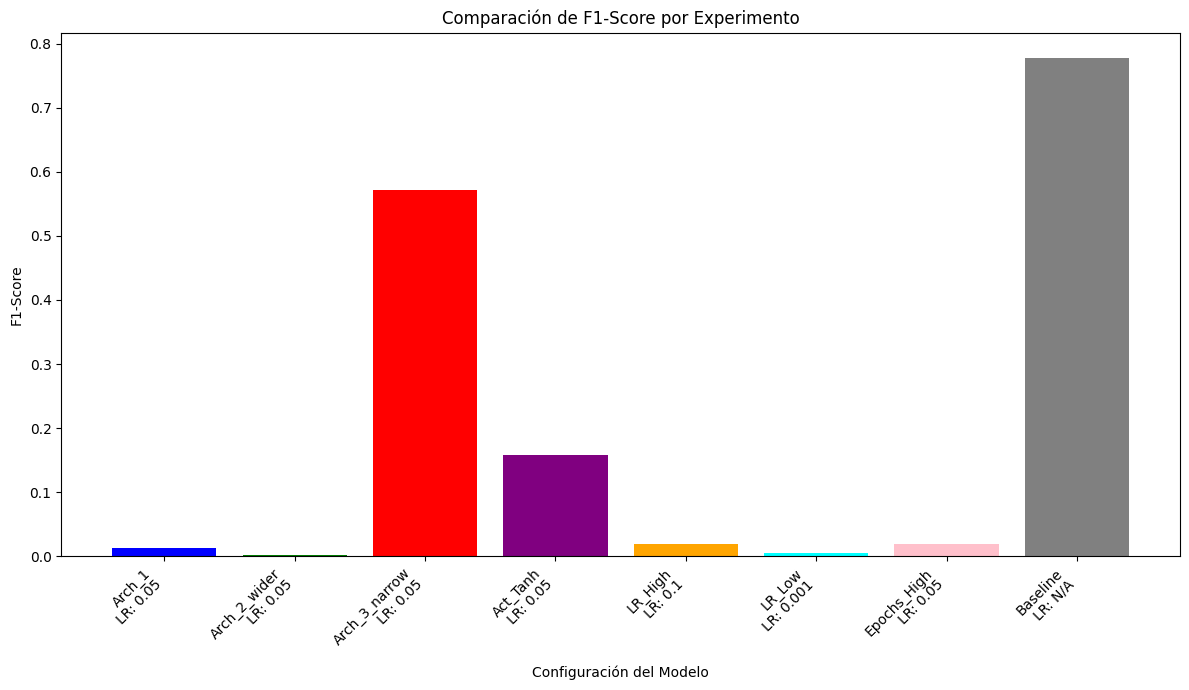

In [22]:
# Cargar datos y ejecutar experimentos

import importlib
# Importar y recargar el módulo `experiments` para asegurarnos de que se lean los cambios.
import experiments
importlib.reload(experiments)

# Importamos la función principal para correr los experimentos.
from experiments import run_all_experiments

# Cargar el dataset de fraude que se guardó en el notebook 01.
df = pd.read_csv('data/datos_sinteticos_fraude.csv')

# Ejecutar y obtener el DataFrame de resultados.
df_resultados = run_all_experiments(df, 'results')

# Mostrar resultados ordenados por F1-Score para una fácil comparación.
print("Resultados de los experimentos (ordenados por F1-Score):")
print(df_resultados.sort_values(by='f1_score', ascending=False))

# Generar gráficos de comparación (F1-Score)
plt.figure(figsize=(12, 7))

# Crear etiquetas para la barra que incluyan el nombre del experimento y el learning rate.
df_resultados['config_label'] = df_resultados.apply(lambda row: f"{row['nombre_experimento']}\nLR: {row['learning_rate']}", axis=1)
plt.bar(df_resultados['config_label'], df_resultados['f1_score'], color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'pink', 'gray'])
plt.xticks(rotation=45, ha='right')
plt.title("Comparación de F1-Score por Experimento")
plt.xlabel("Configuración del Modelo")
plt.ylabel("F1-Score")
plt.tight_layout()

# Guardar el gráfico en la carpeta de resultados y mostrarlo.
plt.savefig("results/f1_comparison.png")
plt.show()